<a href="https://colab.research.google.com/github/mellalbuquerque/fashiondata/blob/main/Spring_2025_Ready_To_Wear_teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [2]:
!pip install --upgrade fashion_words
from fashion_words import fashion_words

import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import re
import unicodedata
import pandas as pd
import random


# Carregar modelo spaCy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Ajuste do tokenizer para preservar hífens
infixes = nlp.Defaults.infixes
infixes = [pattern for pattern in infixes if "-" not in pattern]
infix_re = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Retrieving data

In [3]:
df = pd.read_csv('corpus_spring2025_ready_to_wear.csv')
articles = df['text'].dropna().tolist()



Pré-processamento de texto

In [4]:
# Função de limpeza de texto
def clean_text(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Tokenização e lematização (com ajuste para palavras hifenizadas)
def lemmatize_article(text):
    doc = nlp(text)
    return [
        token.lemma_ if token.lemma_ != "-PRON-" else token.text  # Evita problemas com pronomes
        for token in doc
        if not token.is_stop and not token.is_punct
    ]


# Combinar lemmas em strings para n-gramas
def combine_lemmas(preprocessed_articles):
    return [" ".join(article) for article in preprocessed_articles]

# Pipeline completo para processamento de artigos
def preprocess_articles(articles):
    cleaned_articles = [clean_text(article) for article in articles]
    lemmatized_articles = [lemmatize_article(article) for article in cleaned_articles]
    combined_articles = combine_lemmas(lemmatized_articles)
    return combined_articles

preprocessed_articles = preprocess_articles(articles)


In [5]:
# 🔹 TESTE FINAL: PRESERVAÇÃO DE PALAVRAS HIFENIZADAS 🔹
# Criamos um pequeno texto de teste contendo palavras compostas com hífen
test_text = "One-piece, maxi-dress e off-shoulder-dress são itens essenciais para a moda."

# Aplicamos o pré-processamento
cleaned_test_text = clean_text(test_text)
lemmatized_test_text = lemmatize_article(cleaned_test_text)

# 🔍 Exibimos o resultado
print("\n📌 Texto original:", test_text)
print("📌 Texto limpo:", cleaned_test_text)
print("📌 Texto lematizado:", " ".join(lemmatized_test_text))

# Agora verificamos se as palavras hifenizadas ainda estão corretas
print("\n🔍 Teste final de palavras hifenizadas no corpus:")
for word in ["one-piece", "maxi-dress", "off-shoulder-dress"]:
    if word in lemmatized_test_text:
        print(f"✅ {word} foi mantido corretamente!")
    else:
        print(f"❌ {word} foi perdido! 🚨")



📌 Texto original: One-piece, maxi-dress e off-shoulder-dress são itens essenciais para a moda.
📌 Texto limpo: one-piece maxi-dress e off-shoulder-dress sao itens essenciais para a moda
📌 Texto lematizado: one-piece maxi-dress e off-shoulder-dress sao itens essenciais para moda

🔍 Teste final de palavras hifenizadas no corpus:
✅ one-piece foi mantido corretamente!
✅ maxi-dress foi mantido corretamente!
✅ off-shoulder-dress foi mantido corretamente!


# **Dicionário de moda**

In [6]:
# 📌 **1️⃣ Definição do Dicionário Único de Moda**
fashion_categories = {
    "silhouettes_and_fitting":
     ["a-line", "asymmetric styling", "bias/bias cut", "empire waist", "leg-of-mutton sleeve",
        "line", "agoda sleeve", "panniers", "peplum", "polonaise", "princess line", "shift",
        "tuck", "watteau back", "amf-stitch", "accordion fold", "agassis", "asymmetric", "anti fit",
        "balconnet", "diagonal cut", "drop waist", "drop-tail style", "draping", "empire line",
        "flared leg", "french leg cutout", "h-line", "hip tube", "i-line", "kimono sleeve",
        "layering look", "loose fit", "low waist", "high waist", "natural waistline",
        "off-the-shoulder", "one-shoulder dress", "oversize", "queen anne neckline",
        "racer back", "racerback", "regular fit", "slim fit", "straight fit", "scoop-neck",
        "tea length", "strapless", "v-neck", "wasp waist", "x-line", "y-line",
        "wrapped silhouette", "collarless", "belted", "peplum shape with drop shoulders",
        "bubble hem", "sculptural shapes"],

    "techniques_and_finishes":
     ["appliqué", "batik", "boiled wool", "bugle beads", "chine/warp print", "embroidery",
        "face", "galloon", "gathers", "gimp", "lace and tatting", "bobbin lace", "needlepoint lace",
        "frivolité", "tatting", "macramé", "shibori", "soutache braid", "spangles", "sequins",
        "paillettes", "tie dye", "tuck", "amf-stitch", "accent", "acid wash", "anti pilling",
        "antique look", "authentic finish", "bonding", "burnout", "breaking-in", "calendering",
        "cannélé fabric", "combed yarn", "double-dyed", "destroyed-look", "diamond wash", "edge",
        "epaulette", "embellishment", "equipment", "fitting", "flounce", "finish", "flocking",
        "foto prints", "felled seam", "flatlock seam", "flock print", "flotation", "garment wash",
        "gaufrage", "gentle", "glacé finish", "handstich", "heavy-washed-look", "hairline strips",
        "impregnation", "intarsia", "interlock", "inverted pleat", "jacquard", "knot yarn",
        "köper", "twill", "lasercut", "lavalbel", "mercerizing", "milky wash", "mirror seam",
        "micro cut", "madeira embroidery", "natural stretch", "offside fabric", "oil wash",
        "overdyeing", "overlock stitch", "ombre", "princess seam", "padding", "patchwork", "piping",
        "plissé", "placement printing", "pigment dyeing", "pre-shrunk", "sanforized", "ratinate",
        "real dyeing", "refinement", "relief embroidery", "richelieu embroidery", "rinsewash",
        "ripstop", "reversible", "sand wash", "sanding", "sartorial production", "saxony",
        "seamless", "singeing", "stone wash", "superwash", "selvage", "teflon coating", "tucked hem",
        "twist", "twist yarn", "used look", "vanished", "warp knit", "waxing", "wet look",
        "wrinkle-free laundry", "zirconia", "washed silk", "texture", "fringe", "crochet"],

    "garment_construction_and_components": ["armseye/armscye", "basque", "bishop sleeve", "batwing/dolman sleeve", "bustle",
        "buttonholes", "bretelles", "dart", "ease", "frog", "godet", "gore", "gusset", "hems",
        "plain hem", "rolled hem", "faced hem", "pile", "placket", "pleat", "knife pleats",
        "box pleats", "inverted pleats", "sunburst/accordion pleats", "kick pleats", "raglan",
        "ruching", "seam", "plain seam", "flat felled seam", "french seam", "brush train",
        "bellows pocket", "badge", "bateau neckline", "boat neck", "boning", "border", "billet pocket",
        "button fly", "cagoule", "cape", "cowl collar", "crater shape collar", "cup collar",
        "cut-outs", "dachkragen", "shawl", "revers", "danton collar", "dolman sleeves", "dropped sleeve",
        "emblem", "eyelet", "filling", "fly label", "gathered sleeve cuff", "golf fold", "galloon stripe",
        "grosgrain", "haberdashery", "halterneck", "hood", "horn buttons", "janus sleeve", "half raglan",
        "jewel neckline", "jabot", "kangaroo pocket", "kent collar", "lavaliere bow", "mandarin collar",
        "membrane", "napoleon collar", "neckband collar", "neckholder", "necktie", "obi", "page sleeves",
        "pagoda sleeves", "parricide collar", "pelerine", "piped pocket", "posaments", "raglan sleeve",
        "renaissance sleeve", "ruffle", "ruffle collar", "ruffle lapel", "rhinestones", "safety pocket",
        "shawl collar", "swingpocket", "suspenders", "tab collar", "tipped lapel", "towel collar",
        "turtle neck", "waterfall collar", "wing collar", "zipper puller"],

    "accessories":
     ["balaclava", "basket bag", "bonnet", "cap", "hat", "fedora", "homburg", "havelock",
        "messenger bag", "minaudière", "pouch bag", "signature bag", "gamsbart", "bandana",
        "baseball-cap", "baguette bag", "boa", "canotier", "charm bracelet", "charms", "choker",
        "cloche", "clutch bag", "fanny packs", "hobo bag", "suspenders", "jewelry", "kelly-bag",
        "loop", "plastron", "pashmina", "pillbox hat", "pochette", "scarf", "shoulder bag",
        "stola", "toque", "tote bag", "weekender", "wing bag", "basket-bag", "crossbody-bag",
        "bag", "briefcase", "crossbody bag", "raffia-hat", "sunhat", "straw-hat", "beret",
        "raffia hat", "straw hat", "sunglasses", "cat-eye-sunglasses", "sunglass", "glasses",
        "cat eye sunglasses", "cat-eye sunglasses", "shell-jewelry", "turquoise-necklace",
        "hoops", "stacked-bangles", "ring", "necklace", "earring", "bracelets", "shell jewelry",
        "turquoise necklace", "stacked bangles", "hair-clips", "hair clips", "belt", "bow-tie",
        "bow tie", "mittens", "watch", "woven-sandals", "espadrilles", "woven sandals"],

    "footwear":
     ["blucher", "d’orsay shoe or slipper", "espadrille", "loafer", "penny loafer",
        "tassel-top loafer", "chain loafer", "gucci™ loafer", "mule", "oxford",
        "ankle boots", "babouches", "budapest", "ballerinas", "chelsea boots", "chukka boots",
        "cuirassier boots", "desert boots", "eyelet", "flip-flops", "gillie", "kitten heels",
        "low shoes", "mary jane", "miranda pumps", "moccasins", "moonboots", "overknees",
        "pantolette", "peep toe", "pumps", "roman sandals", "sabots", "sabrina heel",
        "sandals", "slingbacks", "slippers", "sneakers", "wedges", "boots", "ankle-boots",
        "army-boots", "dress-boots", "trekking-boots", "wellington-boots", "work-boots",
        "army boots", "dress boots", "trekking boots", "wellington boots", "work boots",
        "flat sandals", "platform sandals", "gladiator sandals", "t-strap", "peep toes",
        "high-heels", "heels", "stilettos", "trainer-shoes", "slip-on", "loafers",
        "moccasin", "mules", "ballerinas flats", "chukkas", "slipper", "clogs", "slingback"],

    "clothing_pieces":
     ["bustier", "camisole/camisole top", "cheongsam", "hoop/crinoline", "shift",
        "sheath dress", "ankle jeans", "agassis", "anorak", "asia shirt", "ball gown",
        "ballon trousers", "banana skirt", "barbour-jacke", "battle dress", "bergère dress",
        "between length", "bikerjacke", "blazer", "bloomers", "blouson", "bomber jacket",
        "bowling-bluse", "breeches", "bell skirt", "bell-bottom pants", "bell bottom",
        "bootcut", "caban-jacket", "cache-coeur", "calecon pants", "canadian", "caprihose",
        "capuchon-pullover", "cargo pant", "catsuit", "chasuble", "chiton", "clochartdhose",
        "coach coat", "complet", "corso jackett", "cropped jeans", "cut-pants", "cycling shorts",
        "dandy", "debardeur", "deux-pièces", "djellabah", "down jacket", "dragoner", "dressing gown",
        "dufflecoat", "dungarees", "dust coat", "dessous", "ensemble", "etui dress", "far west dress",
        "field jacket", "fireplace skirt", "fishing pants", "fishtail skirt", "five pocket-jeans",
        "flare pants", "flood pants", "flutter pants", "footless pants", "frock coat", "gaucho pant",
        "gilet", "girlie shirt", "harem pants", "hip-skirt", "hip-huggers", "harley davidson jacket",
        "hawaii shirt", "hip strings", "hoodie", "hot pants", "janker", "jeans", "jeggings",
        "jodhpur pants", "jogging pants", "jogn jeans", "joppe", "jumper", "jumpsuit", "kaftan",
        "knickerbockers", "labcoat", "lambada suit", "leotard", "long blouse", "long sleeve shirt",
        "longjohn", "longline pants", "marlene trousers", "micro-mini", "mini", "microkini",
        "monokini", "minimizer bra", "molded bra", "marinière", "mexican skirt", "norfolk jacket",
        "overall", "palazzo pants", "pencil skirt", "padded bra", "paletot", "parka", "panty",
        "pareo", "pilot shirt", "polo shirt", "poncho", "pullunder", "pyjamas", "quilted jackets",
        "redingote", "rider coat", "saddle skirt", "sheath waistcoat", "shift dress", "swinger",
        "saharanne jacket", "shirtdress", "single-breasted", "sarong", "sarouel pants", "scrubs",
        "shorty", "soft pants", "sports bra", "suit jacket", "shape wear", "tailleurs", "tank top",
        "tapered leg", "topless dress", "tulip skirt", "torero pants", "troyer", "turtleneck sweater",
        "thong", "tankini", "tracksuit", "trenchcoat", "triangle bra", "twin set", "two-in-one",
        "unitard", "underwired bra", "vest", "ulster", "wiggle dress", "western skirt",
        "winter jacket", "windbreaker", "buoyant cotton skirts", "buoyant cotton dresses",
        "wind-resistant jackets", "fitted zip-up jackets", "oversized shacket-meets-coat hybrid",
        "cropped leather cape", "pinstripe pants", "caftan", "sundress", "maxi dress", "midi dress",
        "mini dress", "halter dress", "slip dress", "wrap dress", "flowy dress", "off-shoulder dress",
        "wrap skirt", "pleated skirt", "bathing suit", "swimsuit", "one-piece", "high-waisted bikini",
        "kimono cover-up", "bandeau top", "wide leg pants", "culottes", "cropped pants",
        "high-waisted shorts", "bermuda shorts", "t-shirt", "shirt", "sweater", "suit",
        "overcoat", "pantyhose", "stockings", "nightgown"],

    "fabrics":
     ["generic fiber name", "ground", "lace", "lyocell fiber", "manufactured fiber",
        "non-wovens", "bark cloth", "weaving", "knitting", "knotting", "crocheting",
        "stitch-bonding", "weave types", "urdume", "plain weave", "twill weave", "satin weave",
        "weft and warp knits", "weft knits", "jersey", "knitted velour", "terrycloth", "fleece",
        "plush", "doubleknits", "warp knits", "tricots", "raschel knits", "yarn types",
        "filament yarns", "staple yarns", "single yarn", "ply yarn", "cord yarn", "simple yarns",
        "novelty yarns", "slub yarn", "bouclé yarn", "acetat", "airbag fabrics", "ajour pattern",
        "alpaca wool", "angora wool", "bi-elastic", "baby cord", "batist", "blended fabric",
        "boiled wool", "breathable clothing", "camel hair", "canvas", "cashmere", "ceramic fibers",
        "changeant", "charmelaine", "chenille", "chevreau", "chiffon", "coarse linen", "cord",
        "cordinelli", "crepe", "cupro", "curly", "drill", "damassé", "denim", "donegal tweed",
        "tweed", "double fabric", "dupioni", "elasthan", "elastomultiester", "effect yarn",
        "easy-iron laundry", "felt", "filamente", "fine knit", "fleece yarn", "flokati", "flor",
        "foulé", "fuzzy hair", "foulard", "flame yarn", "fake fur", "gabardine", "gauze",
        "georgette", "givré", "glacé leather", "gore-tex", "guipure lace", "gum-twill",
        "high twist", "hopsack", "panamá", "himalaya-loden", "honan silk", "harris tweed",
        "homespun", "hunza loden", "imprimé", "irisé", "japanese silk", "japon", "kabik",
        "kashgora", "lambswool", "lammvelours", "lamé", "leather imitation", "linen", "loden",
        "lycocell", "matelassé", "man-made fibers", "melange", "merino wool", "mesh", "milanorib",
        "microfibers", "modal", "mohair", "moleskin", "mouliné", "muslin", "neoprene", "nonwoven",
        "nubuck", "nutria", "nappa leather", "nettle", "nicky", "nylon", "opaque", "organic cotton",
        "organza", "outlast", "pannesamt", "parachute silk", "patent leather", "peau de soie",
        "piqué", "polyacryl", "polyamide", "polyester", "polyurethane", "popeline", "precious hair",
        "quilt", "raw denim", "ramie", "rips", "sackcloth", "sweat material", "satin", "seersucker",
        "shantung", "silk", "silk crepe", "single jersey", "slinky", "smooth leather", "softshell",
        "strie cloth", "suede", "suede leather", "synthetics", "tactel", "taffeta", "teddy",
        "techno cotton", "techno fabrics", "terry", "terry cloth", "toile", "tulle", "tweed yarn",
        "twill", "valencienne lace", "velvet", "velveton", "vicuna", "viscose", "voile", "wild silk",
        "wool", "wool velvet", "cotton", "poplin", "airy-cotton", "sheer", "bamboo", "raffia",
        "crochet", "knit", "broderie-anglaise", "eyelet", "lightweight-wool", "leather", "corduroy",
        "flannel", "jacquard", "synthetic-fibre", "stonewashed", "distressed", "pleated",
        "embroidered", "crystal-embellished", "metallic-thread", "lurex", "batiste"],

    "styles": [
        "sportswear", "active wear", "adventure style", "avantgarde", "american style",
        "androgyn", "anti fashion", "anti fit", "au naturel", "baby doll style", "barfly clothing",
        "bavaria look", "biba", "british understatement", "brocade", "beach wear", "baroque design",
        "basics", "black tie", "boho style", "border style", "carmen style", "casual wear",
        "chalet style", "comeback", "cosmopolitan style", "cruise style", "customized",
        "dandy-style", "minimalist", "maximalist", "clean", "clean girl", "deauville-style",
        "easy wear", "eclectic style", "eco look", "edgy", "ethno-style", "exotic style",
        "flamenco fashion", "fun couture", "functional clothing", "garçon-look", "flapper look",
        "gothic-look", "grunge-fashion", "gym-look", "home wear", "mix-and-match", "hippie-look",
        "hipster", "invisible style", "jackie-o-style", "lounge wear", "athleisure", "boho",
        "layering", "livery style", "military look", "menswear look", "masculine style",
        "minimalism", "maritime style", "monochrome", "nude-look", "oversized", "office wear",
        "overdressed", "outdoor clothing", "panache", "peek-a-boo style", "power dressing",
        "pure look", "retro style", "spencer combination", "shabby chic", "sports wear",
        "streetwear", "survival-look", "three-piece", "tailor look", "throwback fashion",
        "transitional fashion", "trekking style", "understatement", "unisex", "urban elegance",
        "vintage look", "vigorous", "xxl-look", "workwear", "white tie", "summertime prep",
        "crafty minimalism", "exaggerated proportions", "femininity unraveled", "spring outerwear",
        "checks and balances", "new business codes", "nirvana", "country living"
    ],
    "patterns_and_prints": [
        "ajour pattern", "allover print", "arabesques", "aran pattern", "argyle pattern",
        "awning strips", "baker's square", "baroque design", "bird's-eye pattern",
        "burberry check", "cable pattern", "camouflage pattern", "chalk strips",
        "checking", "chevron", "classic designs", "glencheck", "houndstooth",
        "pinstripes", "dessin", "faux uni", "floral pattern", "grisaille",
        "handkerchief check", "herringbone pattern", "graphic", "ikat pattern",
        "liberty fabrics", "madras plaid", "millefleurs", "minimal print", "microdessins",
        "multicolor", "norwegian pattern", "nova check", "nurse strips", "old tartans",
        "paisley", "plaid", "plaid check", "pucci print", "python look", "regatta strip",
        "rhombic pattern", "stencil print", "salt and pepper pattern", "sari stripes",
        "shadow print", "tapestry pattern", "tartan", "thread check", "towel caros",
        "vichy check", "wrapped look", "sailor stripe", "retro-inspired patterns",
        "plaid in spring", "floral", "tropical", "palm leaf", "seashell motif", "striped",
        "nautical stripes", "glen plaid", "windowpane", "gingham", "checkerboard",
        "geometric", "herringbone", "argyle", "swirl", "mosaic", "abstract", "art-deco",
        "marble", "gradient", "watercolor", "ikat", "tie-dye", "batik", "chinoiserie",
        "damask", "jacquard", "baroque", "animal print", "zebra print", "leopard print",
        "snake print", "ocean waves", "cloud print", "sunburst", "stars", "moon phases",
        "lace pattern", "devoré", "burnout", "brocade", "embroidered", "metallic thread",
        "mesh pattern", "foil print", "textured", "embossed", "polka-dots", "spotted",
        "camouflage", "patchwork", "solid", "polka dots"
    ],
    "colors": [
      "24k gold", "absolute zero", "acid green", "aero", "african violet", "air force blue", "air superiority blue",
    "alabaster", "alice blue", "alizarin", "alloy orange", "almond", "amaranth", "amaranth deep purple",
    "amaranth pink", "amaranth purple", "amazon", "amber", "amethyst", "android green", "antique brass",
    "antique bronze", "antique fuchsia", "antique ruby", "antique white", "apple blossom", "apricot", "aqua",
    "aqua blue", "aquamarine", "arabian green", "arctic blue", "arctic lime", "army green", "artichoke green",
    "arylide yellow", "ash", "ash gray", "atomic tangerine", "aubergine", "aureolin", "avocado green", "azure",
    "azure (x11/web color)", "azure blue", "b'dazzled blue", "baby blue", "baby blue eyes", "baby pink",
    "baby powder", "baker-miller pink", "ballet-slipper", "banana mania", "barbie pink", "barn red",
    "battleship grey", "beau blue", "beaver", "beige", "big dip o’ruby", "bisque", "bistre", "bistre brown",
    "bitter lemon", "black", "black bean", "black coral", "black olive", "black shadows", "blanched almond",
    "blast-off bronze", "bleu de france", "blizzard blue", "blood red", "blue", "blue (crayola)", "blue (munsell)",
    "blue (ncs)", "blue (pantone)", "blue (pigment)", "blue bell", "blue jeans", "blue sapphire", "blue yonder",
    "blue-gray (crayola)", "blue-violet", "bluetiful", "blush", "bold red", "bole", "bone", "bottle green", "brick",
    "brick red", "bright lilac", "bright yellow (crayola)", "british racing green", "bronze", "brown",
    "brown sugar", "bubblegum", "bubblegum pink", "bud green", "buff", "burgundy", "burlywood", "burnished brown",
    "burnt orange", "burnt sienna", "burnt umber", "butter", "butter yellow", "butter-yellow", "buttercup",
    "byzantine", "byzantium", "cadbury purple", "cadet blue", "cadet grey", "cadmium green", "cadmium orange",
    "cafe au lait", "café au lait", "café noir", "cambridge blue", "camel", "cameo pink", "canary",
    "canary yellow", "candy floss", "candy pink", "caramel", "cardinal", "cardinal red", "caribbean green",
    "carmine", "carmine (m&p)", "carnation pink", "carnelian", "carolina blue", "carrot", "carrot orange",
    "catawba", "cedar chest", "celadon", "celeste", "cerise", "cerulean", "cerulean (crayola)", "cerulean (rgb)",
    "cerulean blue", "cerulean frost", "chalk", "chalk white", "champagne", "champagne pink", "charcoal",
    "charcoal black", "charm pink", "chartreuse", "chartreuse (web)", "cherry", "cherry blossom pink",
    "chestnut", "chili red", "china pink", "chinese red", "chinese violet", "chinese yellow", "chocolate",
    "chocolate (traditional)", "chocolate (web)", "chocolate brown", "cinereous", "cinnabar", "cinnamon satin",
    "citrine", "citron", "claret", "cloud", "cloud white", "cobalt", "coffee", "columbia blue", "concrete",
    "congo pink", "cool grey", "copper", "copper (crayola)", "copper penny", "copper red", "copper rose",
    "coquelicot", "coral", "coral pink", "cordovan", "corn", "cornflower", "cornflower blue", "cornsilk",
    "cosmic cobalt", "cosmic latte", "cotton candy", "coyote brown", "cream", "crimson", "crimson (ua)",
    "cultured pearl", "cyan", "cyan (process)", "cyber grape", "cyber yellow", "cyclamen", "daffodil",
    "damson", "dandelion", "dark brown", "dark byzantium", "dark cyan", "dark electric blue", "dark goldenrod",
    "dark green (x11)", "dark jungle green", "dark khaki", "dark lava", "dark liver (horses)", "dark magenta",
    "dark olive green", "dark orange", "dark orchid", "dark purple", "dark red", "dark salmon",
    "dark sea green", "dark sienna", "dark sky blue", "dark slate blue", "dark slate gray", "dark spring green",
    "dark turquoise", "dark violet", "davy's grey", "deep brown", "deep cerise", "deep champagne",
    "deep chestnut", "deep gray", "deep jungle green", "deep pink", "deep purple", "deep saffron",
    "deep sky blue", "deep space sparkle", "deep taupe", "deep teal", "denim", "denim blue", "desert",
    "desert sand", "dewberry", "dim gray", "dodger blue", "doll pink", "dolphin", "dove", "drab dark brown",
    "driftwood gray", "duke blue", "dusky blue", "dutch white",
    "earthy brown", "ebony", "ecru", "eerie black", "eggplant", "eggshell", "electric lime", "electric purple",
    "electric violet", "emerald", "eminence", "english lavender", "english red", "english vermillion",
    "english violet", "erin", "espresso", "eton blue", "fallow", "falu red", "fandango", "fandango pink", "fawn",
    "fern", "fern green", "field drab", "fiery rose", "fig", "finn", "fire engine red", "firebrick", "flame",
    "flamingo", "flax", "flint", "flirt", "floral white", "fog", "forest", "forest green", "forest green (web)",
    "french beige", "french bistre", "french blue", "french fuchsia", "french lilac", "french lime", "french mauve",
    "french navy", "french pink", "french raspberry", "french sky blue", "french violet", "frog green", "frostbite",
    "fuchsia", "fuchsia (crayola)", "fulvous", "fuscia", "fuzzy wuzzy", "gainsboro", "gamboge", "gardenia", "garnet",
    "generic viridian", "geranium", "ghost white", "ginger", "glaucous", "glossy grape", "go green", "gold",
    "gold (crayola)", "gold (metallic)", "gold (web) (golden)", "gold fusion", "golden brown", "golden poppy",
    "golden yellow", "goldenrod", "gotham green", "gradations", "granite gray", "granny smith apple", "graphite",
    "gray (web)", "gray (x11 gray)", "green", "green (crayola)", "green (munsell)", "green (ncs)", "green (pantone)",
    "green (pigment)", "green (web)", "green lizard", "green sheen", "green-blue", "gunmetal", "hansa yellow",
    "harlequin", "harvest gold", "heat wave", "heather gray", "heliotrope", "heliotrope gray", "hematite",
    "hollywood cerise", "honey", "honolulu blue", "hooker's green", "hot magenta", "hot pink", "hunter green",
    "ice blue", "ice white", "iceberg", "icy blue", "illuminating emerald", "imperial red", "inchworm",
    "independence", "india green", "indian red", "indian yellow", "indigo", "indigo dye", "ink",
    "international klein blue", "international orange (engineering)", "international orange (golden gate bridge)",
    "iris", "iris blue", "irresistible", "isabelline", "italian sky blue", "ivory", "jade", "japanese carmine",
    "japanese violet", "jasmine", "jazzberry jam", "jet", "jonquil", "june bud", "jungle green", "kelly green",
    "keppel", "key lime", "khaki (web)", "khaki (x11) (light khaki)", "kobe", "kobi", "kobicha", "kohl",
    "ksu purple", "languid lavender", "lapis blue", "lapis lazuli", "laser lemon", "latte", "laurel green", "lava",
    "lavender", "lavender (floral)", "lavender (web)", "lavender blue", "lavender blush", "lavender gray",
    "lawn green", "leather", "lemon", "lemon chiffon", "lemon curry", "lemon glacier", "lemon meringue",
    "lemon sorbet", "lemon yellow", "lemon yellow (crayola)", "liberty", "light blue", "light coral",
    "light cornflower blue", "light cyan", "light french beige", "light goldenrod yellow", "light gray",
    "light green", "light orange", "light periwinkle", "light pink", "light purple", "light salmon",
    "light sea green", "light sky blue", "light slate gray", "light steel blue", "light taupe", "light yellow",
    "lilac", "lilac luster", "lime", "lime (color wheel)", "lime (web) (x11 green)", "lime green", "lime-green",
    "lincoln green", "linen", "lion", "liseran purple", "little boy blue", "liver", "liver (dogs)", "liver (organ)",
    "liver chestnut", "livid", "lizard grey", "lobelia",
    "macaroni and cheese", "madder lake", "magenta", "magenta (crayola)", "magenta (dye)", "magenta (pantone)",
    "magenta (process)", "magenta haze", "magic mint", "magnolia", "mahogany", "mahogony", "maize", "maize (crayola)",
    "majorelle blue", "makeup tones", "malachite", "manatee", "mandarin", "mango", "mango tango", "mantis",
    "mardi gras", "marigold", "maroon", "maroon (crayola)", "maroon (web)", "maroon (x11)", "mauve", "mauve taupe",
    "mauvelous", "maximum blue", "maximum blue green", "maximum blue purple", "maximum green", "maximum green yellow",
    "maximum purple", "maximum red", "maximum red purple", "maximum yellow", "maximum yellow red", "may green",
    "maya blue", "medium aquamarine", "medium blue", "medium candy apple red", "medium carmine", "medium champagne",
    "medium orchid", "medium purple", "medium sea green", "medium slate blue", "medium spring green",
    "medium turquoise", "medium violet-red", "melanin", "mellow apricot", "mellow yellow", "melon", "metallic gold",
    "metallic seaweed", "metallic sunburst", "mexican pink", "middle blue", "middle blue green", "middle blue purple",
    "middle green", "middle green yellow", "middle grey", "middle purple", "middle red", "middle red purple",
    "middle yellow", "middle yellow red", "midnight", "midnight blue", "midnight green (eagle green)",
    "mikado yellow", "milk white", "millenial pink", "mimi pink", "mindaro", "ming", "minion yellow", "mint",
    "mint cream", "mint green", "minty green", "misty moss", "misty rose", "moccasin", "mocha", "mode beige",
    "mona lisa", "morning blue", "moroccan blue", "moss", "moss green", "mountain meadow", "mountbatten pink",
    "msu green", "mulberry", "mulberry (crayola)", "mustard", "mustard yellow", "myrtle green", "mystic",
    "mystic maroon", "nadeshiko pink", "naples yellow", "navajo white", "navy blue", "navy blue (crayola)", "neon",
    "neon blue", "neon fuchsia", "neon green", "neon pink", "neon yellow", "neutrals", "new car", "new york pink",
    "nickel", "nightshade", "non-photo blue", "nyanza", "oak", "obsidian", "ocean-blue", "ochre", "old burgundy",
    "old gold", "old lace", "old lavender", "old mauve", "old rose", "old silver", "olive", "olive drab (#3)",
    "olive drab #7", "olive green", "olivine", "onyx", "opal", "opera mauve", "orange", "orange (crayola)",
    "orange (pantone)", "orange (web)", "orange peel", "orange soda", "orange-red", "orange-red (crayola)",
    "orange-yellow", "orange-yellow (crayola)", "orangeade", "orchid", "orchid (crayola)", "orchid pink",
    "ou crimson red", "outer space (crayola)", "outrageous orange", "oxblood", "oxford blue", "pacific blue",
    "pakistan green", "palatinate purple", "pale aqua", "pale cerulean", "pale dogwood", "pale pink",
    "pale purple (pantone)", "pale spring bud", "pale turquoise", "palm green", "pansy purple",
    "paolo veronese green", "papaya", "papaya whip", "paradise pink", "parchment", "paris green", "pastel pink",
    "patriarch", "paua", "payne's grey", "paynes grey", "peach", "peach (crayola)", "peach fuzz", "peach puff",
    "pear", "pearl", "pearly purple", "pebble", "pecan", "penny", "peridot", "periwinkle", "periwinkle (crayola)",
    "permanent geranium lake", "persian blue", "persian green", "persian indigo", "persian orange", "persian pink",
    "persian plum", "persian red", "persian rose", "persimmon", "pewter", "pewter blue", "phlox", "phthalo blue",
    "phthalo green", "pickle", "picotee blue", "pictorial carmine", "piggy pink", "pillar box", "pine", "pine green",
    "pineapple", "pink", "pink (pantone)", "pink lace", "pink lavender", "pink sherbet", "pistachio", "pitch black",
    "platinum", "plum", "plum (web)", "plump purple", "polished pine", "pomp and power", "poppy", "popstar",
    "porcelain", "portland orange", "powder blue", "powder-blue", "prairie gold", "primrose", "princeton orange",
    "prune", "prussian blue", "psychedelic purple", "puce", "pullman brown (ups brown)", "pumpkin", "purple",
    "purple (munsell)", "purple (web)", "purple (x11)", "purple mountain majesty", "purple navy", "purple pizzazz",
    "purple plum", "purpureus",
    "queen blue", "queen pink", "quick silver", "quinacridone magenta", "radical red", "raisin", "raisin black",
    "rajah", "raspberry", "raspberry glacé", "raspberry rose", "raven", "raw sienna", "raw umber", "razzle dazzle rose",
    "razzmatazz", "razzmic berry", "rebecca purple", "red", "red (crayola)", "red (munsell)", "red (ncs)",
    "red (pantone)", "red (pigment)", "red (ryb)", "red salsa", "red-orange", "red-orange (color wheel)",
    "red-orange (crayola)", "red-purple", "red-violet", "red-violet (color wheel)", "red-violet (crayola)", "redwood",
    "resolution blue", "rhythm", "rich black", "rich black (fogra29)", "rich black (fogra39)", "rifle green",
    "robin egg blue", "rocket metallic", "rojo spanish red", "roman silver", "rose", "rose bonbon", "rose dust",
    "rose ebony", "rose madder", "rose pink", "rose pompadour", "rose red", "rose taupe", "rose vale", "rosewood",
    "rosso corsa", "rosy brown", "royal blue", "royal blue (dark)", "royal blue (light)", "royal purple",
    "royal yellow", "ruber", "rubine red", "ruby", "ruby red", "rufous", "russet", "russian green",
    "russian violet", "rust", "rust red", "rusty red", "sacramento state green", "saddle brown", "safety orange",
    "safety orange (blaze orange)", "safety yellow", "saffron", "sage", "salamander", "salmon", "salmon pink",
    "sand", "sand dune", "sandy beige", "sandy brown", "sap green", "sapphire", "sapphire (crayola)",
    "sapphire blue", "satin sheen gold", "scarlet", "schauss pink", "schocking pink", "school bus yellow",
    "screamin' green", "sea glass", "sea green", "sea green (crayola)", "seafoam", "seafoam green", "seal brown",
    "seance", "seashell", "secret", "selective yellow", "sepia", "shadow", "shadow blue", "shamrock green",
    "sheen green", "sherpa blue", "shimmering blush", "shiny shamrock", "shocking pink", "shocking pink (crayola)",
    "sienna", "silver", "silver (crayola)", "silver (metallic)", "silver chalice", "silver pink", "silver sand",
    "sinopia", "siren red", "sizzling red", "sizzling sunrise", "skobeloff", "sky blue", "sky blue (crayola)",
    "sky magenta", "sky-blue", "slate", "slate blue", "slate gray", "slimy green", "smitten", "smoky black",
    "snow", "soft cyan", "soft gray", "soft rose", "soft white", "soil", "solid pink", "sonic silver",
    "space cadet", "spanish bistre", "spanish blue", "spanish carmine", "spanish gray", "spanish green",
    "spanish orange", "spanish pink", "spanish red", "spanish sky blue", "spanish violet", "spanish viridian",
    "spider", "spring bud", "spring frost", "spring green", "spring green (crayola)", "st. patrick's blue",
    "star command blue", "stark white", "steel", "steel blue", "steel pink", "stil de grain yellow", "straw",
    "strawberry", "strawberry blonde", "strong lime green", "sugar plum", "sunglow", "sunny yellow", "sunray",
    "sunset", "sunset-hues", "sunshine yellow", "super pink", "sweet brown", "syracuse orange", "tan",
    "tan (crayola)", "tangerine", "tango pink", "tart orange", "taupe", "taupe gray", "tawny", "tea green",
    "tea rose", "teal", "teal blue", "technobotanica", "telemagenta", "tenné (tawny)", "terra cotta",
    "terracotta", "thistle", "thulian pink", "tickle me pink", "tiffany blue", "timberwolf", "titanium yellow",
    "toffee", "tomato", "tourmaline", "tropical rainforest", "true blue", "true red", "trypan blue", "tufts blue",
    "tumbleweed", "turmeric", "turquoise", "turquoise blue", "turquoise green", "turtle green", "tuscan",
    "tuscan brown", "tuscan red", "tuscan tan", "tuscan-sun", "tuscany", "twilight lavender", "tyrian purple",
    "ua blue", "ua red", "ultra pink", "ultra red", "ultramarine", "ultramarine blue", "umber", "unbleached silk",
    "united nations blue", "university of pennsylvania red", "unmellow yellow", "up forest green", "up maroon",
    "upsdell red", "uranian blue", "usafa blue", "van dyke brown", "vanilla", "vanilla ice", "vegas gold",
    "venetian red", "verdigris", "vermilion", "vermilion (alt.)", "veronica", "violet", "violet (color wheel)",
    "violet (crayola)", "violet (ryb)", "violet (web)", "violet-blue", "violet-blue (crayola)", "violet-red",
    "violet-red (perbang)", "viridian", "viridian green", "vivid burgundy", "vivid sky blue", "vivid tangerine",
    "vivid violet", "volt", "walnut", "warm black", "warm gray", "warm orange", "warm white", "watermelon",
    "weezy blue", "wheat", "white", "wild blue yonder", "wild orchid", "wild strawberry", "wild watermelon",
    "windsor tan", "wine", "wine dregs", "winter sky", "wintergreen dream", "wisteria", "wood brown", "xanadu",
    "xanthic", "xanthous", "yale blue", "yellow", "yellow (crayola)", "yellow (munsell)", "yellow (ncs)",
    "yellow (pantone)", "yellow (process)", "yellow (ryb)", "yellow orange", "yellow orange (color wheel)",
    "yellow sunshine", "yellow-green", "yellow-green (color wheel)", "yellow-green (crayola)", "yinmn blue",
    "zaffre", "zinc", "zinnwaldite brown", "zomp"

    ]
}


N-gramas gerais

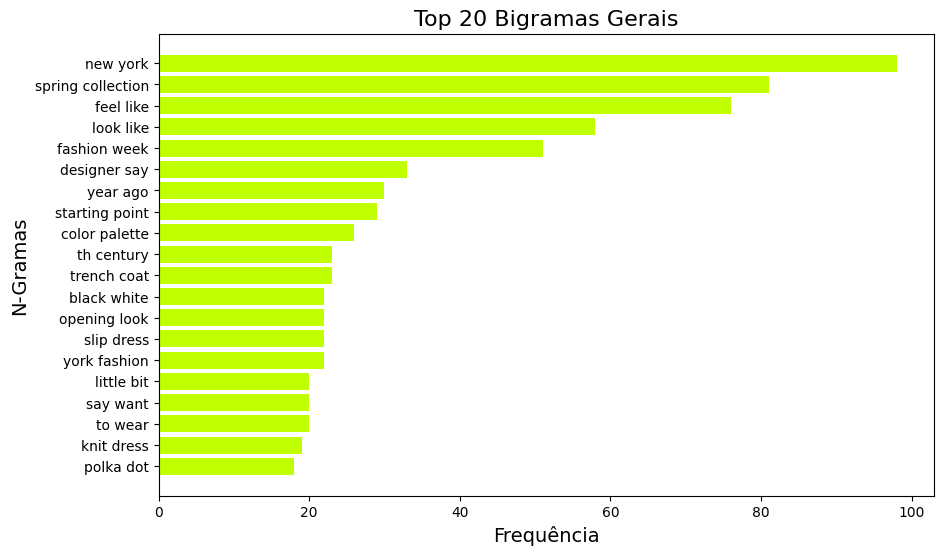

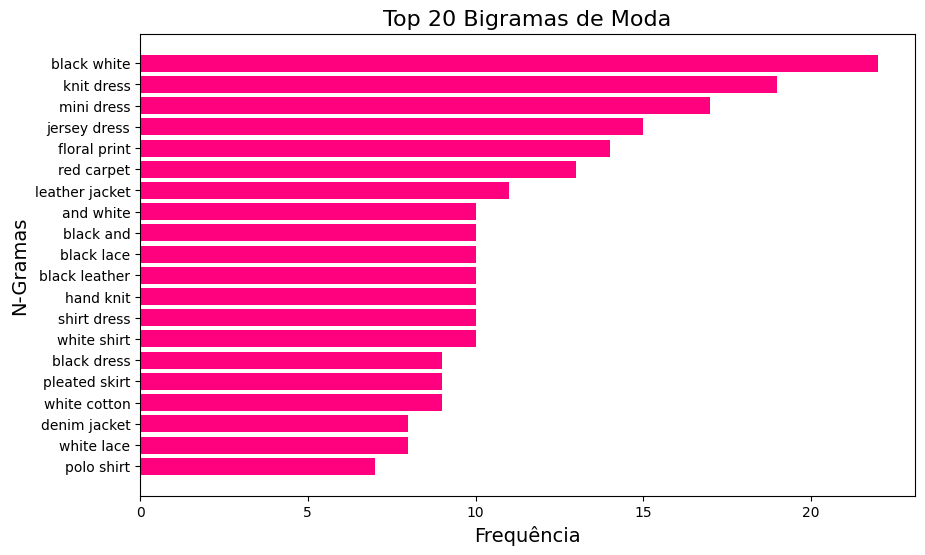

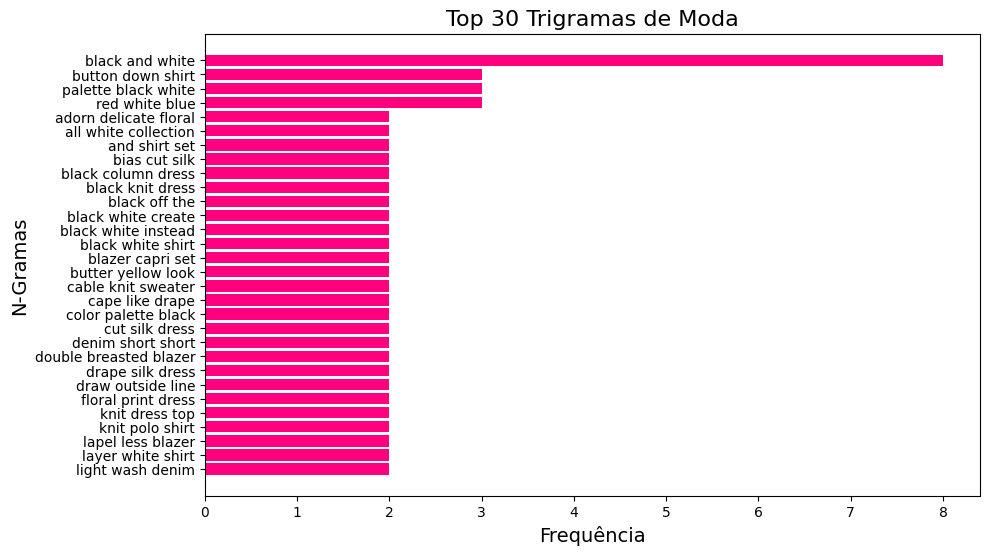

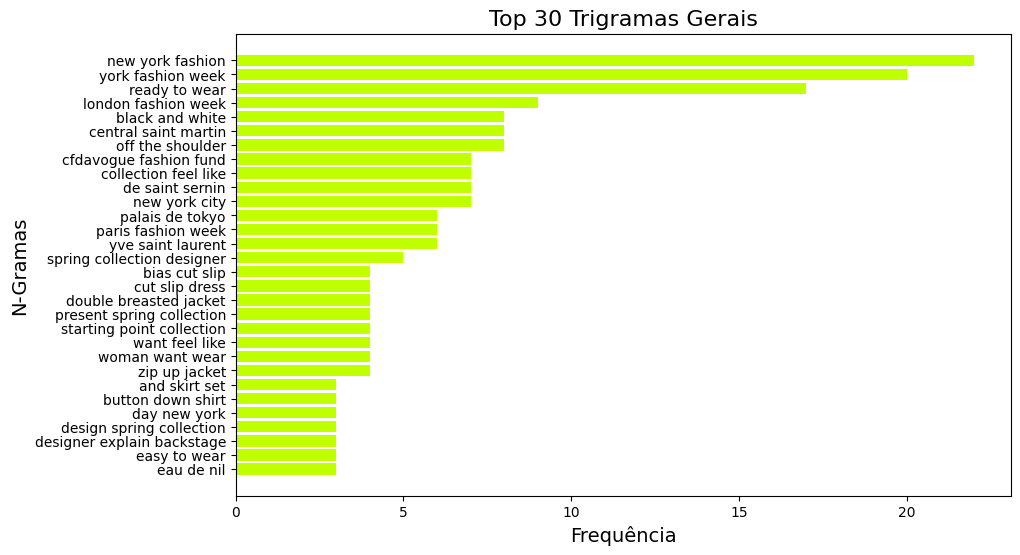

In [8]:
# N-gramas gerais
# %%
# 📌 ** Função para Gerar N-Gramas e Exibir**
def generate_ngrams(corpus, n, top_k=20, filter_fashion=False):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))

    if filter_fashion:
        fashion_set = set(word for category in fashion_categories.values() for word in category)
        ngram_counts = {ngram: count for ngram, count in ngram_counts.items() if any(word in fashion_set for word in ngram.split())}

    return Counter(ngram_counts).most_common(top_k)

def plot_ngrams_color(ngrams, title, color):
    """
    Plota os n-gramas usando uma cor específica.
    - `ngrams`: lista de tuplas (n-grama, frequência)
    - `title`: título do gráfico
    - `color`: cor para as barras (Neon Lime Green para gerais, Neon Pink para moda)
    """
    # Converter os n-gramas para um DataFrame
    df = pd.DataFrame(ngrams, columns=["N-Grama", "Frequência"])

    plt.figure(figsize=(10, 6))
    plt.barh(df["N-Grama"], df["Frequência"], color=color)
    plt.xlabel("Frequência", fontsize=14)
    plt.ylabel("N-Gramas", fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Para que a maior frequência fique no topo
    plt.show()

# 📌 Generating ngrams with the function generate_ngrams
general_bigrams = generate_ngrams(preprocessed_articles, 2, top_k=20) # Generating bigrams for the general corpus
fashion_bigrams = generate_ngrams(preprocessed_articles, 2, top_k=20, filter_fashion=True) # Generating bigrams for the fashion corpus
general_trigrams = generate_ngrams(preprocessed_articles, 3, top_k=30) # Generating trigrams for the general corpus
fashion_trigrams = generate_ngrams(preprocessed_articles, 3, top_k=30, filter_fashion=True) # Generating trigrams for the fashion corpus

# Exibir gráficos com cores distintas:
plot_ngrams_color(general_bigrams, "Top 20 Bigramas Gerais", "#C0FF00")
plot_ngrams_color(fashion_bigrams, "Top 20 Bigramas de Moda", "#FF007F")
plot_ngrams_color(fashion_trigrams, "Top 30 Trigramas de Moda", "#FF007F")
plot_ngrams_color(general_trigrams, "Top 30 Trigramas Gerais", "#C0FF00")

Nuvem de palavras

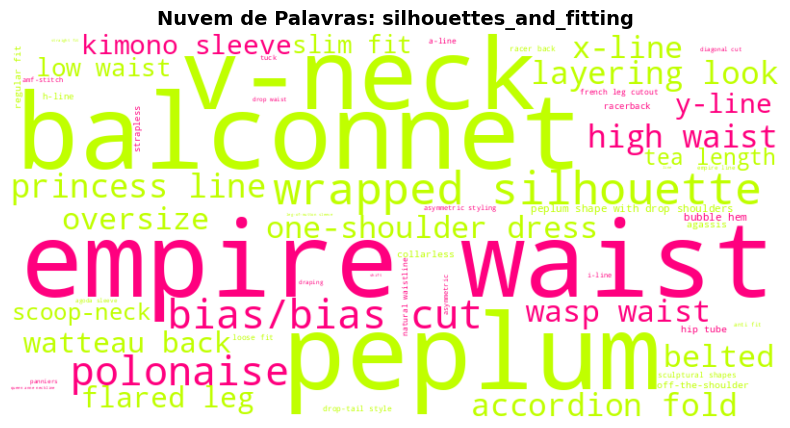

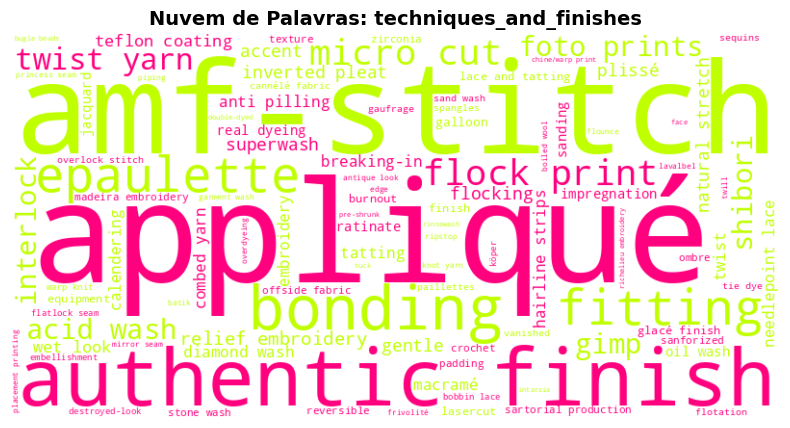

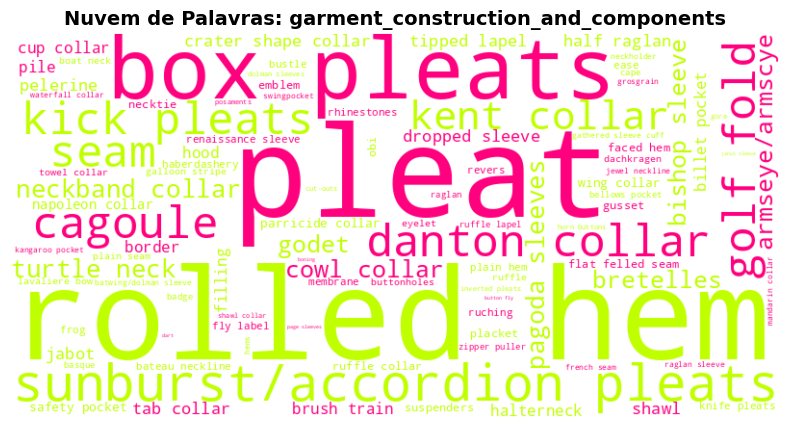

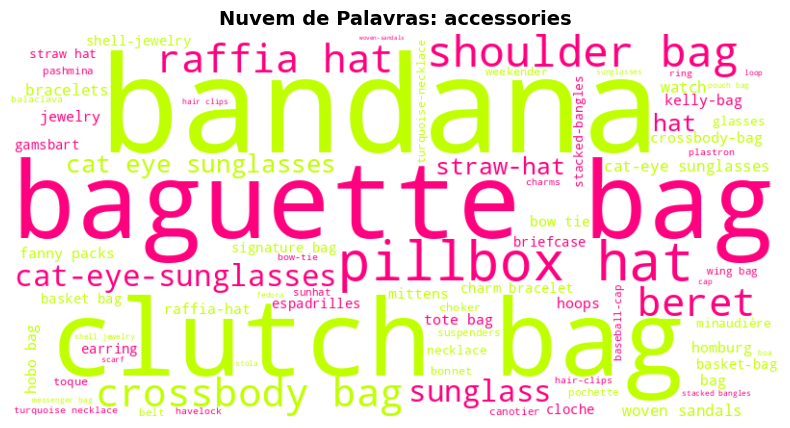

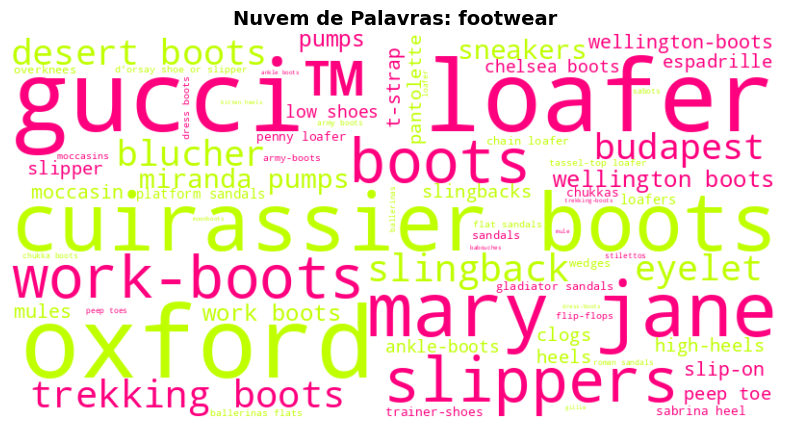

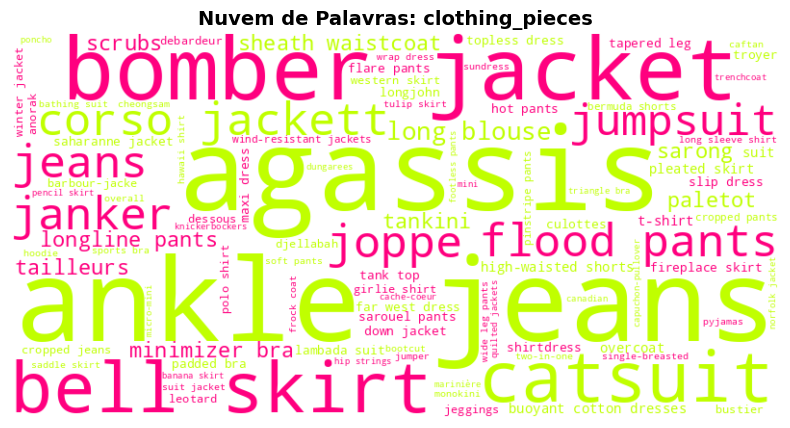

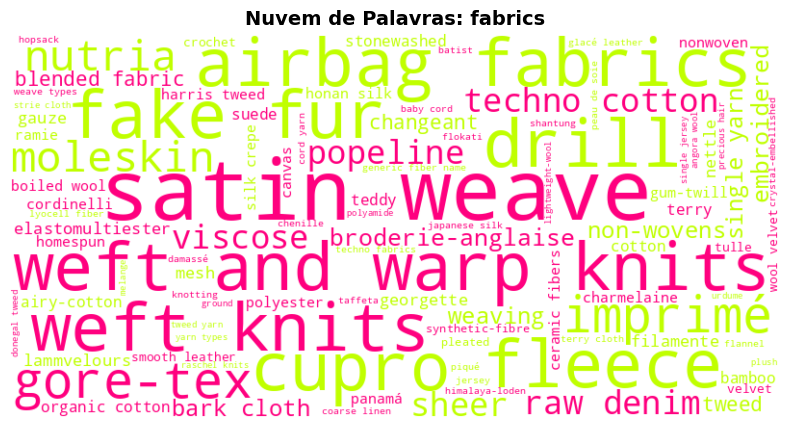

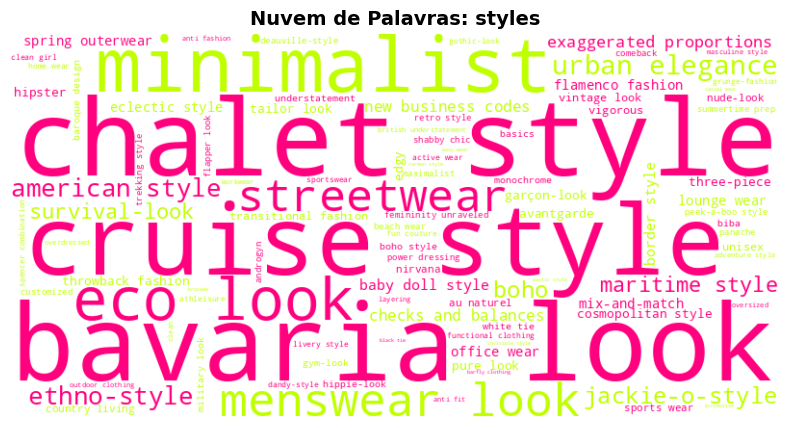

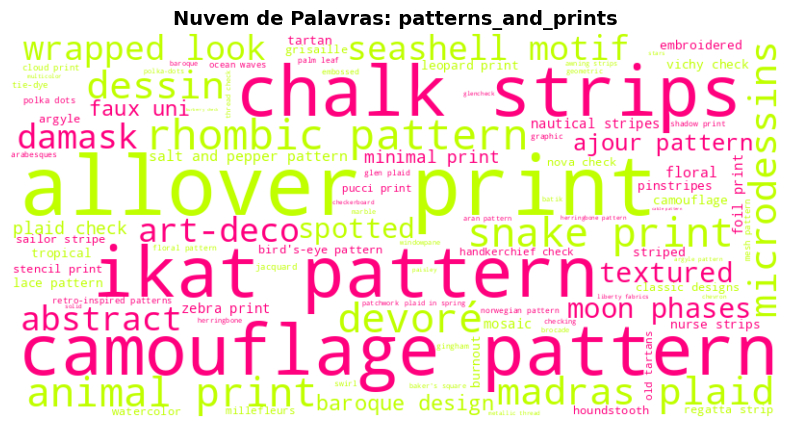

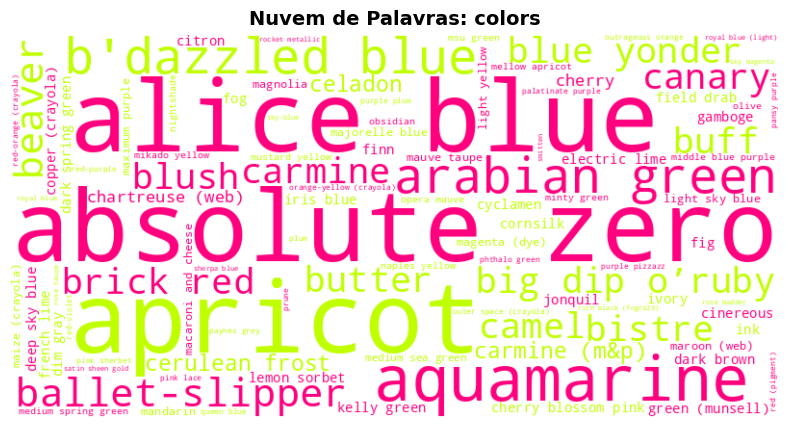

In [9]:
# 📌 **3️⃣ Função para Criar Nuvem de Palavras**
def color_function(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(["#FF007F", "#C0FF00"])  # Neon Pink e Neon Lime Green

def criar_nuvem(categoria, palavras):
    contagem = Counter({word: random.randint(1, 10) for word in palavras})
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        color_func=color_function
    ).generate_from_frequencies(contagem)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuvem de Palavras: {categoria}", fontsize=14, fontweight="bold", color="black")
    plt.show()

# 📌 **4️⃣ Gerar Nuvem de Palavras para Cada Categoria**
for categoria, palavras in fashion_categories.items():
    criar_nuvem(categoria, palavras)
